In [19]:
%matplotlib notebook
import math
import pandas as pd
from kmodes import kmodes
import csv
from sklearn import cluster
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from kmodes.kprototypes import KPrototypes
from matplotlib import style
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
from scipy.stats import pearsonr

In [20]:
# simplify housing dataset
housing = pd.read_csv('train.csv', na_values=[None,'None'])

## modify housing cols
- manually look into data description
- remove cols that look very trivial in real world just for the simplicity of the project

In [21]:
drop_housing_cols = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Utilities', 'MSSubClass', 'RoofMatl','ExterCond','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','Heating','CentralAir','Electrical','LowQualFinSF','1stFlrSF','2ndFlrSF','Functional','GarageArea','GarageQual','GarageCond','3SsnPorch','EnclosedPorch','WoodDeckSF','OpenPorchSF',\
                     'ScreenPorch','PoolArea','PoolQC','MiscVal','Street','LandContour','LandSlope',\
                    'Fireplaces','PavedDrive','Exterior2nd','Condition2','LotFrontage']
housing1 = housing.drop(drop_housing_cols, axis=1)
housing1 = housing1.set_index('Id')
housing1 = housing1[(housing1['MSZoning'] != 'C (all)') & (housing1['MSZoning'] != 'FV')]

- correct outliers
- change ratings & sortable categories to numeric
- insert NAN w/ reasonable number

In [22]:
# # convert LotArea to categorical
# # modify outliers
# housing1['LotArea'] = housing1['LotArea'].apply(lambda x: housing1['LotArea'].quantile(0.95) if x > housing1['LotArea'].quantile(0.95) else x)
# # housing1['LotArea'] = pd.cut(housing1['LotArea'],10)

# # convert LotShape to numerical
dict1 = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
housing1['LotShape'] = housing1['LotShape'].apply(lambda x: dict1[x])

# # convert YearBuilt to categorical
# # modify outliers
# housing1['YearBuilt'] = housing1['YearBuilt'].apply(lambda x: housing1['YearBuilt'].quantile(0.01) if x < housing1['YearBuilt'].quantile(0.01) else x)
# # housing1['YearBuilt'] = pd.cut(housing1['YearBuilt'], 10)

# # convert YearRemodAdd to categorical
# # housing1['YearRemodAdd'] = pd.cut(housing1['YearRemodAdd'], 10)

# # convert MasVnrArea to categorical
# housing1['MasVnrArea'] = housing1['MasVnrArea'].apply(lambda x: housing1['MasVnrArea'].quantile(0.9) if x > housing1['MasVnrArea'].quantile(0.9) else x)
# # housing1['MasVnrArea'] = pd.cut(housing1['MasVnrArea'], 10)

# # convert TotalBsmtSF to categorical
# housing1['TotalBsmtSF'] = housing1['TotalBsmtSF'].apply(lambda x: housing1['TotalBsmtSF'].quantile(0.95) if x > housing1['TotalBsmtSF'].quantile(0.95) else x)
# # housing1['TotalBsmtSF'] = pd.cut(housing1['TotalBsmtSF'], 10)

# # convert GrLivArea to categorical
# housing1['GrLivArea'] = housing1['GrLivArea'].apply(lambda x: housing1['GrLivArea'].quantile(0.95) if x > housing1['GrLivArea'].quantile(0.95) else x)
# # housing1['GrLivArea'] = pd.cut(housing1['GrLivArea'], 10)

# # convert TotRmsAbvGrd to categorical
# # housing1['TotRmsAbvGrd'] = pd.cut(housing1['TotRmsAbvGrd'], 5)

# # convert GarageYrBlt to categorical
# housing1['GarageYrBlt'] = housing1['GarageYrBlt'].apply(lambda x: housing1['GarageYrBlt'].quantile(0.01) if x < housing1['GarageYrBlt'].quantile(0.01) else x)
# # housing1['GarageYrBlt'] = pd.cut(housing1['GarageYrBlt'], 10)

# # convert SalePrice to categorical
# housing1['SalePrice'] = housing1['SalePrice'].apply(lambda x: int(housing1['SalePrice'].quantile(0.95)) if x > housing1['SalePrice'].quantile(0.95) else int(x))
# # housing1['SalePrice'] = pd.cut(housing1['SalePrice'], 20)

# convert rating to numeric
dict2 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1, np.nan: 0}
modify_col1 = ['ExterQual','HeatingQC','KitchenQual','FireplaceQu','BsmtQual',\
              'BsmtCond']
for col in modify_col1:
    housing1[col] = housing1[col].apply(lambda x: dict2[x])
dict5 = {'Gd': 3, 'Av':2, 'Mn': 1, 'No':0, np.nan: 0}
housing1['BsmtExposure'] = housing1['BsmtExposure'].apply(lambda x: dict5[x])

# convert garage NA to meaningful terms
housing1['GarageType'] = housing1['GarageType'].apply(lambda x: 'NoGarage' if x is np.nan else x)
dict3 = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0}
housing1['GarageFinish'] = housing1['GarageFinish'].apply(lambda x: dict3[x])
dict4 = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0}
housing1['Fence'] = housing1['Fence'].apply(lambda x: dict4[x])

## cluter the house
- initialize features
    - without NaN
    - not explicit filter

In [23]:
# initialize cluster features
not_na_col = set(housing1.columns[housing1.notnull().all()].tolist())
explicit = set(['SalePrice', 'LotArea', 'GarageCars', 'FullBath', 'BedroomAbvGr'])
init_features = not_na_col - explicit
print(init_features)

{'BsmtCond', 'TotalBsmtSF', 'HouseStyle', 'GarageType', 'GrLivArea', 'YearRemodAdd', 'KitchenAbvGr', 'BsmtExposure', 'OverallQual', 'FireplaceQu', 'Condition1', 'YearBuilt', 'LotConfig', 'Exterior1st', 'KitchenQual', 'MSZoning', 'BsmtHalfBath', 'LotShape', 'BldgType', 'GarageFinish', 'TotRmsAbvGrd', 'HeatingQC', 'OverallCond', 'HalfBath', 'Fence', 'RoofStyle', 'Foundation', 'Neighborhood', 'ExterQual', 'BsmtFullBath', 'BsmtQual'}


- cluster with all initialized features
    - cluster of 5 seems reasonable
    - centeroids of ['MSZoning','LotConfig','BldgType','RoofStyle','Condition1'] look all the same, remove them from potential features

In [24]:
#Data points with their publisher name,category score, category name, place name
cat_col = ['MSZoning','LotConfig','Neighborhood','BldgType','HouseStyle','RoofStyle',\
           'GarageType','Foundation','Exterior1st','Condition1']
num_col = ['LotShape','HalfBath','TotRmsAbvGrd','GrLivArea','KitchenAbvGr','FireplaceQu',\
          'OverallQual','TotalBsmtSF','YearRemodAdd', 'OverallCond','HeatingQC','YearBuilt', \
           'BsmtFullBath', 'KitchenQual','Fence','BsmtCond', 'LotShape','ExterQual','BsmtQual',\
           'BsmtHalfBath','GarageFinish','BsmtExposure']
def k_prototype_cluster(cat_col, num_col, housing1,last_cost = 2e10,initial_n = 3):
    proto_data = housing1[cat_col + num_col]
    proto_train1 = proto_data.values
    improvement = 0.5
    x_list = []
    y_list = []
    impro_list = []
    cluster_result = dict()
#     while improvement > 0.1:
    while initial_n <= 20:
        kproto = KPrototypes(n_clusters=initial_n, verbose=0)
        clusters = kproto.fit(proto_train1,categorical=range(len(cat_col))).predict(proto_train1,categorical=range(len(cat_col)))
        improvement = 1.0 - kproto.cost_ / last_cost
#         improvement = 1.0 - (kproto.cost_/initial_n) / (last_cost/(initial_n-1))
        last_cost = kproto.cost_
        x_list += [kproto.n_clusters]
        y_list += [kproto.cost_]
        impro_list += [improvement]
        cluster_result[initial_n] = [kproto, clusters]
        initial_n += 1
    return x_list, y_list, impro_list, cluster_result

def plot_cluster_cost(result, y=0.2):
    x_list, y_list, impro_list, cluster_result = result
    ax1 = plt.axes()  # standard axes
    ax2 = plt.axes([0.65, 0.65, 0.2, 0.2])
    ax1.set_title('cost of cluster size n')
    ax2.set_title('cost improvement')
    ax2.axhline(y, color='b', linestyle='-')
    ax2.axhline(y-0.1, color='b', linestyle='-')
    ax1.plot(x_list, y_list)
    ax2.plot(x_list, impro_list)

In [16]:
# ipython notebook --matplotlib=inline
result1 = k_prototype_cluster(cat_col, num_col, housing1)

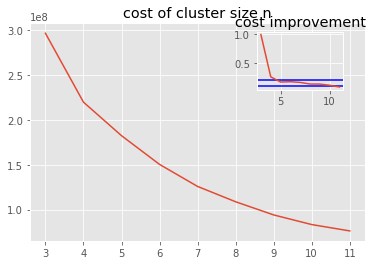

In [18]:
%matplotlib inline
plot_cluster_cost(result1, 0.2)

In [40]:
# print(cluster_result[10][0].cluster_centroids_)
# cluster_result[initial_n] = [kproto, clusters]
a = 10
numcents = result1[3][a][0].cluster_centroids_[0]
catcents = result1[3][a][0].cluster_centroids_[1]
cents_df = pd.DataFrame(columns=num_col, index=range(a))
for i in range(a):
    cents_df.loc[i] = list(numcents[i])
cents_df
# 'MSZoning','BldgType','Condition1'

ValueError: cannot copy sequence with size 22 to array axis with dimension 7

- cluster with reduced categorical features
    - cluster of 10/11 seems reasonable
    - centeroids of ['LotShape', 'KitchenAbvGr', 'OverallCond', 'BsmtFullBath', 'BsmtCond','BsmtHalfBath'] dont vary much (varied within 0.5)
    - approach 1: change them to categorical
    - approach 2: ignore them

In [41]:
cat_col = ['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st','LotConfig','RoofStyle']
num_col = ['LotShape','HalfBath','TotRmsAbvGrd','GrLivArea','KitchenAbvGr','FireplaceQu',\
          'OverallQual','TotalBsmtSF','YearRemodAdd', 'OverallCond','HeatingQC','YearBuilt', \
           'BsmtFullBath', 'KitchenQual','Fence','BsmtCond', 'LotShape','ExterQual','BsmtQual',\
           'BsmtHalfBath','GarageFinish','BsmtExposure']
result2 = k_prototype_cluster(cat_col,num_col,housing1)

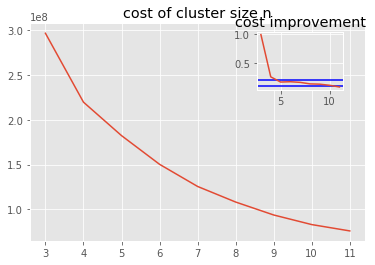

In [42]:
%matplotlib inline
plot_cluster_cost(result2)

In [44]:
# 'OverallCond', 'Fence', 'BsmtHalfBath'
numcents = result2[3][a][0].cluster_centroids_[0]
catcents = result2[3][a][0].cluster_centroids_[1]
cents_df = pd.DataFrame(columns=num_col, index=range(a))
for i in range(a):
    cents_df.loc[i] = list(numcents[i])
cents_df

,LotShape,HalfBath,TotRmsAbvGrd,GrLivArea,KitchenAbvGr,FireplaceQu,OverallQual,TotalBsmtSF,YearRemodAdd,OverallCond,...,BsmtFullBath,KitchenQual,Fence,BsmtCond,LotShape,ExterQual,BsmtQual,BsmtHalfBath,GarageFinish,BsmtExposure
0,3.67249,0.0480349,4.72926,881.651,0.995633,0.515284,4.9607,826.188,1975.49,5.91703,...,0.436681,3.13537,0.799127,2.99563,3.67249,3.0655,3.19651,0.0567686,1.1179,0.655022
1,3.86047,0.0232558,5.97674,1202.81,1.34884,0.767442,4.30233,47.6279,1970.7,5.23256,...,0,2.97674,0.55814,0.511628,3.86047,3,0.534884,0.0232558,0.976744,0.116279
2,3.43966,0.801724,8.5,2262.46,1.06897,2.87069,6.90517,1083.26,1990.49,5.57759,...,0.422414,3.80172,0.543103,3.0431,3.43966,3.66379,3.82759,0.0431034,2,0.646552
3,3.43243,0.144144,6.53604,1579.35,1.06306,2.57658,6.77477,1519.44,1993.41,5.18468,...,0.59009,3.81982,0.211712,3.01802,3.43243,3.68018,3.87838,0.0495495,2.11261,1.16667
4,2.6,0.8,10.6,4467.6,1,4,9.6,3457.6,2000,5.2,...,1,4.8,0.6,3,2.6,4.6,4.8,0.2,2.8,2.2
5,3.70968,0.225806,5.70968,1191.42,1.02016,1.33468,5.62097,1138.24,1981.28,5.6371,...,0.580645,3.34274,0.834677,3.02016,3.70968,3.18952,3.43548,0.0927419,1.62097,0.576613
6,3.46032,0.285714,7.80952,2040.79,1.04762,3.60317,8.12698,1997.17,1997.43,5.06349,...,0.698413,4.26984,0.238095,3.04762,3.46032,4.14286,4.42857,0.015873,2.50794,1.61905
7,3.70157,0.492147,6.38743,1347.79,1.02094,1.58115,5.60209,700.565,1978.02,5.9267,...,0.219895,3.22513,0.638743,2.97382,3.70157,3.1466,3.25131,0.0942408,1.51309,0.287958
8,3.32609,0.869565,10.1087,2886.39,1.06522,3.3913,7.73913,1443.02,1994.65,5.80435,...,0.521739,4.06522,0.543478,3.04348,3.32609,3.84783,4.02174,0.0652174,2.17391,0.956522
9,3.52252,0.72973,7.35135,1779.54,1.07207,2.14865,6.27027,864.545,1985.12,5.61712,...,0.27027,3.50901,0.572072,2.98649,3.52252,3.36937,3.49099,0.0315315,1.78829,0.378378


In [ ]:
# approach 1: change quant to cat
cat_col = ['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st','LotShape', 'KitchenAbvGr', 'OverallCond', 'BsmtFullBath', 'BsmtCond','BsmtHalfBath']
num_col = ['HalfBath','TotRmsAbvGrd','GrLivArea','FireplaceQu','OverallQual',\
           'TotalBsmtSF','YearRemodAdd', 'HeatingQC','YearBuilt',\
           'KitchenQual','Fence','ExterQual','BsmtQual','GarageFinish',
           'BsmtExposure']
result2_1 = k_prototype_cluster(cat_col,num_col,housing1)

In [ ]:
plot_cluster_cost(result2_1)

In [ ]:
numcents = result2_1[3][5][0].cluster_centroids_[0]
catcents = result2_1[3][5][0].cluster_centroids_[1]
cents_df = pd.DataFrame(columns=num_col, index=range(5))
for i in range(5):
    cents_df.loc[i] = list(numcents[i])
cents_df
# put to categorical: 'BsmtQual','KitchenQual'
# delete: 'LotShape', 'KitchenAbvGr', 'OverallCond', 'BsmtCond', BsmtHalfBath'

In [ ]:
# iteration 2: 
cat_col = ['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st','BsmtFullBath','KitchenQual','BsmtQual' ]
num_col = ['HalfBath','TotRmsAbvGrd','GrLivArea','FireplaceQu','OverallQual',\
           'TotalBsmtSF','YearRemodAdd', 'HeatingQC','YearBuilt',\
           'Fence','ExterQual','GarageFinish','BsmtExposure']
result2_2 = k_prototype_cluster(cat_col,num_col,housing1)

In [ ]:
plot_cluster_cost(result2_2)

In [ ]:
numcents = result2_2[3][5][0].cluster_centroids_[0]
catcents = result2_2[3][5][0].cluster_centroids_[1]
cents_df = pd.DataFrame(columns=num_col, index=range(5))
for i in range(5):
    cents_df.loc[i] = list(numcents[i])
cents_df
# add to categorical'HalfBath', 'HeatingQC', 'Fence','ExterQual','GarageFinish','BsmtExposure'

In [ ]:
# add to categorical'HalfBath', 'HeatingQC', 'Fence','ExterQual','GarageFinish','BsmtExposure'
# iteration 3: 
cat_col = ['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st','BsmtFullBath',\
           'KitchenQual','BsmtQual','HalfBath', 'HeatingQC', 'Fence','ExterQual',\
           'GarageFinish','BsmtExposure']
num_col = ['TotRmsAbvGrd','GrLivArea','FireplaceQu','OverallQual',\
           'TotalBsmtSF','YearRemodAdd','YearBuilt']
result2_3 = k_prototype_cluster(cat_col,num_col,housing1)

In [ ]:
plot_cluster_cost(result2_3)

In [ ]:
numcents = result2_3[3][5][0].cluster_centroids_[0]
catcents = result2_3[3][5][0].cluster_centroids_[1]
cents_df = pd.DataFrame(columns=cat_col, index=range(5))
for i in range(5):
    cents_df.loc[i] = list(catcents[i])
cents_df
# delete 'Fence', 'BsmtExposure'

In [25]:
cat_col = ['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st','BsmtFullBath',\
           'KitchenQual','BsmtQual','HalfBath', 'HeatingQC', 'ExterQual','GarageFinish']
num_col = ['TotRmsAbvGrd','GrLivArea','FireplaceQu','OverallQual',\
           'TotalBsmtSF','YearRemodAdd','YearBuilt']
result2_4 = k_prototype_cluster(cat_col,num_col,housing1)

<IPython.core.display.Javascript object>


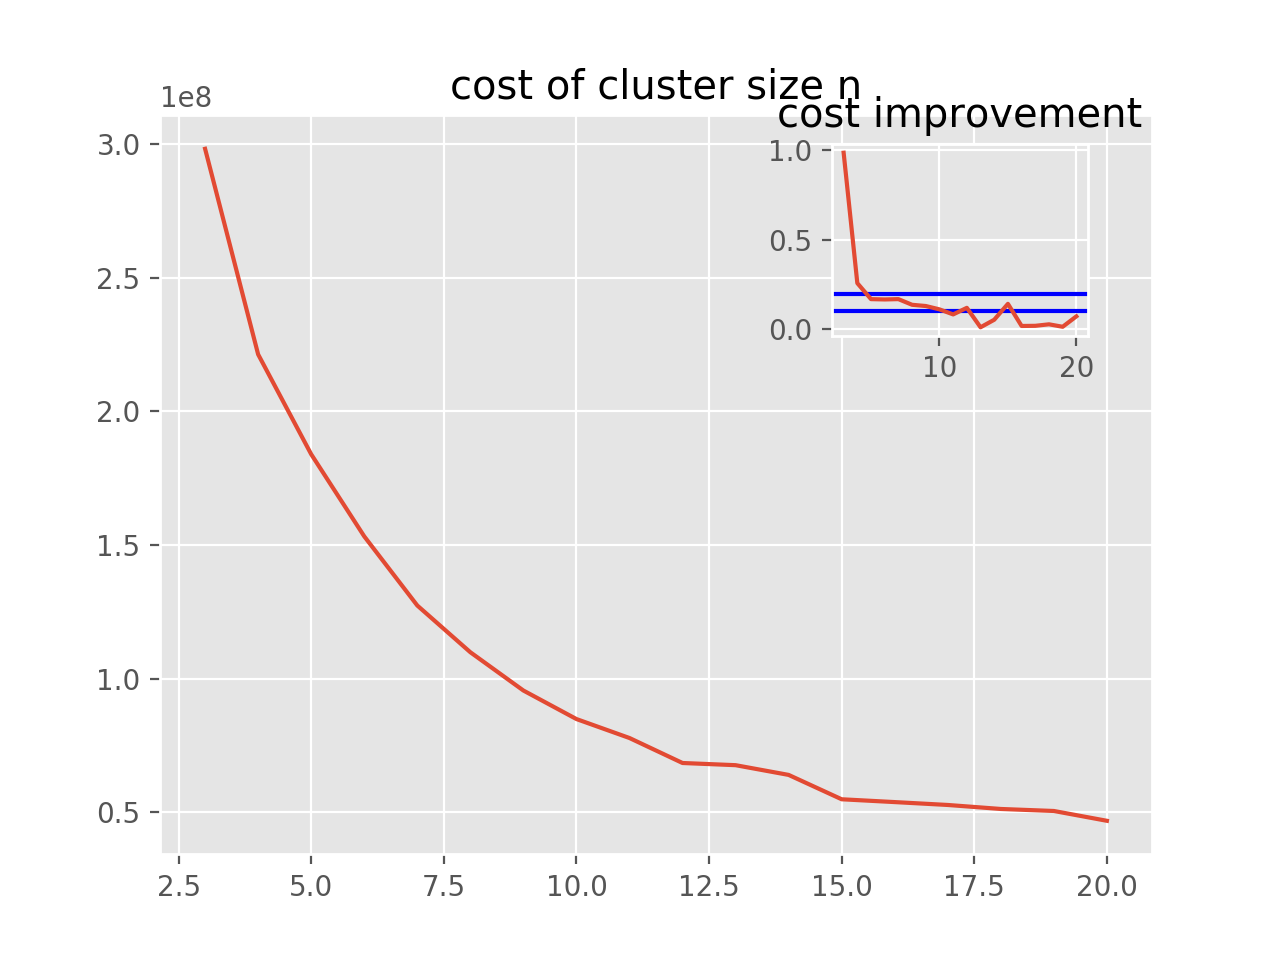

In [32]:
plot_cluster_cost(result2_4)

In [37]:
for a in range(12,13):
    numcents = result2_4[3][a][0].cluster_centroids_[0]
    catcents = result2_4[3][a][0].cluster_centroids_[1]
    cents_df = pd.DataFrame(columns=num_col+cat_col, index=range(a))
    for i in range(a):
        cents_df.loc[i] = list(numcents[i])+list(catcents[i])
    clustered_house = housing1
    clustered_house['group'] = result2_4[3][a][1]
    na_col = clustered_house.columns[clustered_house.isnull().any()].tolist()
#     for i in range(a):
#         clustered_house[clustered_house['group'] == i] = clustered_house[clustered_house['group'] == i].fillna(clustered_house[clustered_house['group'] == i].mode().iloc[0])
#     clustered_house.loc[clustered_house['group'] == 0, 'Alley'] = 'Pave'
    # cols = ['LotArea', 'MasVnrArea','TotalBsmtSF','GrLivArea','SalePrice']
    # for col in cols:
    #     clustered_house[col] = clustered_house[col].apply(lambda x: housing1[col].quantile(0.95) if x > housing1[col].quantile(0.95) else x)

    # cols = ['YearBuilt', 'GarageYrBlt']
    # for col in cols:
    #     clustered_house[col] = clustered_house[col].apply(lambda x: housing1[col].quantile(0.01) if x < housing1[col].quantile(0.01) else x)
    # buckets = {}
    # cols = ['LotArea', 'MasVnrArea','TotalBsmtSF','GrLivArea','YearBuilt', 'GarageYrBlt','YearRemodAdd']
    # for col in cols:
    #     clustered_house[col] = pd.cut(clustered_house[col],10)
    # clustered_house['SalePrice'] = pd.cut(clustered_house['SalePrice'],20)
    # clustered_house['TotRmsAbvGrd'] = pd.cut(clustered_house['TotRmsAbvGrd'],5)
    binary_house = pd.get_dummies(clustered_house, columns=clustered_house.columns[:-1])
    final_house = pd.DataFrame({'whole': dict(zip(binary_house.index,binary_house[[i for i in binary_house.columns.values if i!='group']].values)),
                               'Id': dict(zip(binary_house.index,binary_house.index))},
                              index = binary_house.index.values)
    final_house['group'] = binary_house['group']
    final_house.to_csv('final_house{}.csv'.format(a), index=False)

In [15]:
housing1

,MSZoning,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,TotRmsAbvGrd,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,Fence,MiscFeature,SalePrice,group
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,"(7780.96, 9401.2]",Pave,4,Inside,CollgCr,Norm,1Fam,2Story,7,...,"(6.8, 9.2]",0,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(196313.64, 210714.88]",4
2,RL,"(9401.2, 11021.44]",Pave,4,FR2,Veenker,Feedr,1Fam,1Story,6,...,"(4.4, 6.8]",3,Attchd,"(1973.072, 1982.304]",2,2,0,Shed,"(167511.16, 181912.4]",2
3,RL,"(11021.44, 12641.68]",Pave,3,Inside,CollgCr,Norm,1Fam,2Story,7,...,"(4.4, 6.8]",3,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(210714.88, 225116.12]",4
4,RL,"(9401.2, 11021.44]",Pave,3,Corner,Crawfor,Norm,1Fam,2Story,7,...,"(6.8, 9.2]",4,Detchd,"(1991.536, 2000.768]",1,3,0,Shed,"(138708.68, 153109.92]",4
5,RL,"(12641.68, 14261.92]",Grvl,3,FR2,NoRidge,Norm,1Fam,2Story,8,...,"(6.8, 9.2]",3,Attchd,"(1991.536, 2000.768]",2,3,0,Shed,"(239517.36, 253918.6]",3
6,RL,"(12641.68, 14261.92]",Pave,3,Inside,Mitchel,Norm,1Fam,1.5Fin,5,...,"(4.4, 6.8]",0,Attchd,"(1991.536, 2000.768]",1,2,3,Shed,"(138708.68, 153109.92]",0
7,RL,"(9401.2, 11021.44]",Grvl,4,Inside,Somerst,Norm,1Fam,1Story,8,...,"(6.8, 9.2]",4,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(297122.32, 311523.56]",2
8,RL,"(9401.2, 11021.44]",Grvl,3,Corner,NWAmes,PosN,1Fam,2Story,7,...,"(6.8, 9.2]",3,Attchd,"(1963.84, 1973.072]",2,2,0,Shed,"(196313.64, 210714.88]",4
9,RM,"(4540.48, 6160.72]",Pave,4,Inside,OldTown,Artery,1Fam,1.5Fin,7,...,"(6.8, 9.2]",3,Detchd,"(1926.912, 1936.144]",1,2,0,Shed,"(124307.44, 138708.68]",4


## Make Spider Plot

In [232]:
df = cents_df
# df = pd.get_dummies(df,columns=['Neighborhood','HouseStyle','GarageType','Foundation','Exterior1st'])
df['group'] = cents_df.index.values
df = df[['TotRmsAbvGrd', 'GrLivArea', 'FireplaceQu', 'OverallQual',
       'TotalBsmtSF', 'YearRemodAdd', 'YearBuilt',
       'BsmtFullBath', 'KitchenQual', 'BsmtQual', 'HalfBath', 'HeatingQC',
       'ExterQual', 'GarageFinish', 'group']]

In [233]:
df=df.astype(float)
df.columns.values

array(['TotRmsAbvGrd', 'GrLivArea', 'FireplaceQu', 'OverallQual',
       'TotalBsmtSF', 'YearRemodAdd', 'YearBuilt', 'BsmtFullBath',
       'KitchenQual', 'BsmtQual', 'HalfBath', 'HeatingQC', 'ExterQual',
       'GarageFinish', 'group'], dtype=object)

In [239]:
for col in df.columns.values.tolist()[:-1]:
    df[col]=(df[col]-housing1[col].min())/(housing1[col].max()-housing1[col].min())

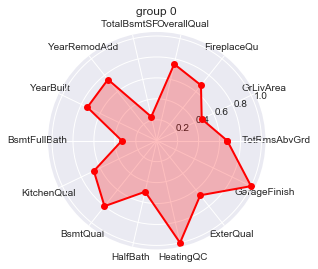

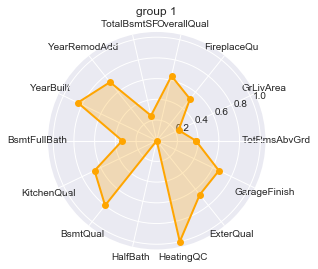

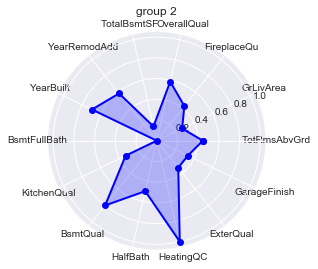

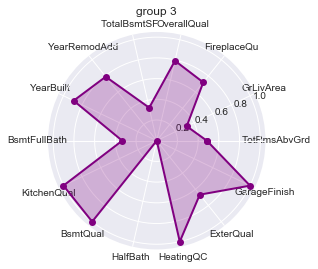

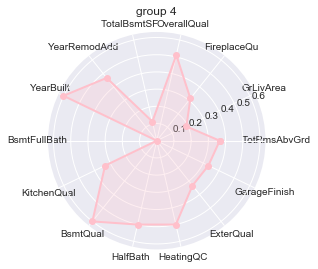

In [245]:
def make_spider(row,color='grey'):
    sns.set()
    labels=list(df)[:-1]
    stats=df.loc[row,labels].values
    
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    
    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, color=color)
    ax.fill(angles, stats, alpha=0.25, color=color)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title('group ' + str(row))
    ax.grid(True)
    
my_dpi=100
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

my_palette = ['red', 'orange','blue','purple','pink','grey','green','black','brown','tan']
for row in range(0, 5):
    make_spider(row=row, color=my_palette[row])

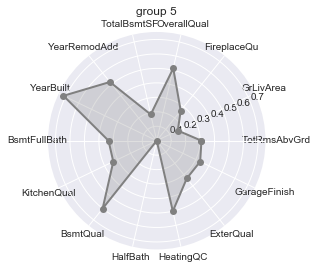

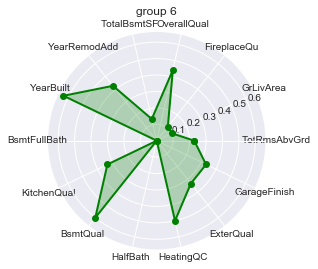

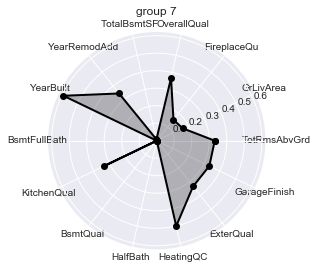

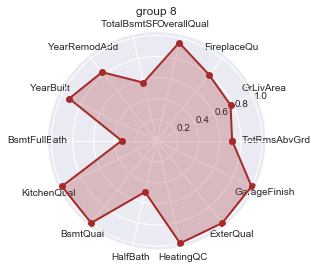

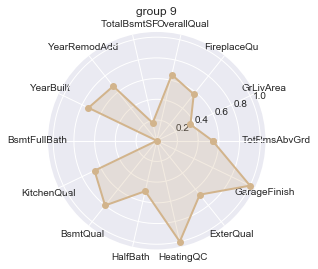

In [246]:
my_dpi=100
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

my_palette = ['red', 'orange','blue','purple','pink','grey','green','black','brown','tan']
for row in range(5, 10):
    make_spider(row=row, color=my_palette[row])

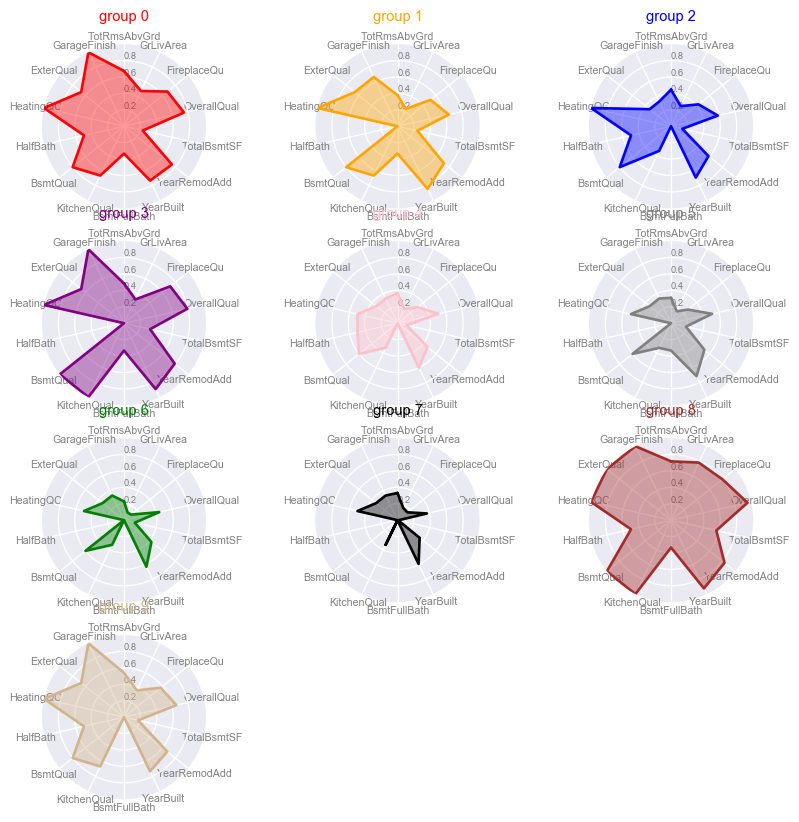

In [249]:
%matplotlib inline
def make_spider(row, title, color):
    categories=list(df)[:-1]
    N = len(categories)
 
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(4,3,row+1, polar=True, )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6",'0.8'], color="grey", size=7)
    plt.ylim(0,1)
 
    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = ['red', 'orange','blue','purple','pink','grey','green','black','brown','tan']
 
# Loop to plot
for row in range(len(df.index)):
    make_spider(row=row, title='group '+ str(row), color=my_palette[row])

## Impute Data Based on Clusters
- add cluster back to proto_data
- groupby cluster
- add NaN w/ centeroid's value

In [257]:
clustered_house = housing1
clustered_house['group'] = result2_4[3][10][1]

In [258]:
na_col = clustered_house.columns[clustered_house.isnull().any()].tolist()
for i in range(5):
    clustered_house[clustered_house['group'] == i] = clustered_house[clustered_house['group'] == i].fillna(clustered_house[clustered_house['group'] == i].mode().iloc[0])
clustered_house.loc[clustered_house['group'] == 0, 'Alley'] = 'Pave'
# clustered_house = clustered_house[list(set(clustered_house.columns.values) - set(clustered_house.describe().columns.values)) + clustered_house.describe().columns.values.tolist()]                               

In [259]:
clustered_house.describe()
# clustered_house.describe().columns.values.tolist()

,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,Fence,SalePrice,group
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.00000,1385.000000,1385.000000
mean,9781.363899,3.581949,6.063538,5.607942,1970.181805,1984.121300,92.185560,3.374729,3.462816,2.929964,...,1.048375,3.493863,6.537906,1.854874,1977.328895,1.703249,1.753791,0.58917,175702.883032,4.045487
std,3538.871807,0.584573,1.373366,1.125799,29.465898,20.554236,138.795045,0.566729,0.885144,0.562693,...,0.224508,0.665086,1.624029,1.807145,24.001599,0.895975,0.755061,1.22511,65451.237994,2.436496
min,1300.000000,1.000000,1.000000,1.000000,1897.200000,1950.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,0.000000,1917.680000,0.000000,0.000000,0.00000,37900.000000,0.000000
25%,7711.000000,3.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,3.000000,3.000000,3.000000,...,1.000000,3.000000,5.000000,0.000000,1962.000000,1.000000,1.000000,0.00000,129000.000000,2.000000
50%,9591.000000,4.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,3.000000,3.000000,3.000000,...,1.000000,3.000000,6.000000,2.000000,1977.000000,2.000000,2.000000,0.00000,160000.000000,4.000000
75%,11751.000000,4.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,4.000000,4.000000,3.000000,...,1.000000,4.000000,7.000000,4.000000,2000.000000,2.000000,2.000000,0.00000,212900.000000,6.000000
max,17502.400000,4.000000,10.000000,9.000000,2010.000000,2010.000000,447.000000,5.000000,5.000000,4.000000,...,3.000000,5.000000,14.000000,5.000000,2010.000000,3.000000,4.000000,4.00000,325924.800000,9.000000


In [260]:
# convert to bins

# convert LotArea to categorical
# modify outliers
cols = ['LotArea', 'MasVnrArea','TotalBsmtSF','GrLivArea','SalePrice']
for col in cols:
    clustered_house[col] = clustered_house[col].apply(lambda x: housing1[col].quantile(0.95) if x > housing1[col].quantile(0.95) else x)

cols = ['YearBuilt', 'GarageYrBlt']
for col in cols:
    clustered_house[col] = clustered_house[col].apply(lambda x: housing1[col].quantile(0.01) if x < housing1[col].quantile(0.01) else x)

In [267]:
buckets = {}
cols = ['LotArea', 'MasVnrArea','TotalBsmtSF','GrLivArea','YearBuilt', 'GarageYrBlt','YearRemodAdd']
for col in cols:
    clustered_house[col] = pd.cut(clustered_house[col],10)

clustered_house['SalePrice'] = pd.cut(clustered_house['SalePrice'],20)
clustered_house['TotRmsAbvGrd'] = pd.cut(clustered_house['TotRmsAbvGrd'],5)

In [268]:
binary_house = pd.get_dummies(clustered_house, columns=clustered_house.columns[:-1])
binary_house

,group,MSZoning_RH,MSZoning_RL,MSZoning_RM,"LotArea_(1283.798, 2920.192]","LotArea_(2920.192, 4540.384]","LotArea_(4540.384, 6160.576]","LotArea_(6160.576, 7780.768]","LotArea_(7780.768, 9400.96]","LotArea_(9400.96, 11021.152]",...,"SalePrice_(181882.32, 196280.552]","SalePrice_(196280.552, 210678.784]","SalePrice_(210678.784, 225077.016]","SalePrice_(225077.016, 239475.248]","SalePrice_(239475.248, 253873.48]","SalePrice_(253873.48, 268271.712]","SalePrice_(268271.712, 282669.944]","SalePrice_(282669.944, 297068.176]","SalePrice_(297068.176, 311466.408]","SalePrice_(311466.408, 325864.64]"
Id,,,,,,,,,,,,,,,,,,,,,
1,2,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,5,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,9,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8,9,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
9,2,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
binary_house = pd.get_dummies(clustered_house, columns=clustered_house.columns[:-1])
final_house = pd.DataFrame({'whole': dict(zip(binary_house.index,binary_house[[i for i in binary_house.columns.values if i!='group']].values))},
                          index = binary_house.index.values)     
final_house['group'] = binary_house['group']
final_house.to_csv('final_house5.csv')

In [272]:
final_house.to_csv('final_house5.csv')

In [230]:
selected = [10, 9, 4, 15, 2, 73, 1, 3, 23, 5, 26, 14, 190, 7, 12, 534, 376, 30,
            18, 39]
final_house.loc[selected]['whole'].to_csv('template_house.csv')

In [229]:
b

10     [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...
9      [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4      [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
15     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
2      [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
73     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
1      [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
3      [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...
23     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
5      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...
26     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...
14     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
190    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
7      [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
12     [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...
534    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
376    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...
30     [0, 0, 1, 0, 0, 0, 1, 0,

In [132]:
final_house.to_csv('final_house1.csv')

In [207]:
binary_house[[col for col in binary_house.columns.values.tolist() if 'SalePrice' in col]].drop_duplicates().index
# [1, 3, 4, 7, 12, 14, 15, 18, 30, 54, 59, 162, 179, 441, 692, 770,804, 899]

Int64Index([1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 15, 18, 23, 26, 30, 39, 73, 190,
            376, 534],
           dtype='int64', name='Id')

In [208]:
# cols = binary_house.columns.values.tolist()
# a = 0
# for i,item in enumerate(cols):
#     if item == 'LotArea_(1086.055, 22694.5]':
#         a = i
#         break
# selected = [1, 3, 4, 7, 12, 14, 15, 18, 30, 54, 59, 162, 179, 441, 692, 770,804, 899]
# template = pd.DataFrame(columns=cols[i:], index=selected)
# for index in selected:
#     template.loc[index] = binary_house[cols[i:]].loc[index]
cols = binary_house.columns.values.tolist()
a = 0
for i,item in enumerate(cols):
    if item == 'LotArea_(1086.055, 22694.5]':
        a = i
        break
selected = [1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 15, 18, 23, 26, 30, 39, 73, 190,376, 534]
template = pd.DataFrame(columns=cols, index=selected)
for index in selected:
    template.loc[index] = binary_house.loc[index]

In [227]:
pd.get_dummies(template[template.columns[:-1]].sort_values('SalePrice')).index

Int64Index([10, 9, 4, 15, 2, 73, 1, 3, 23, 5, 26, 14, 190, 7, 12, 534, 376, 30,
            18, 39],
           dtype='int64')

In [222]:
temp_house = pd.DataFrame({'whole': dict(zip(template.index,template.sort_values('SalePrice').values))},
                          index = template.index.values)     
# final_house['group'] = binary_house['group']
# temp_house
temp_house.to_csv('template_house.csv')

In [223]:
temp_house

,whole
1,"[RL, (6160.72, 7780.96], Grvl, 4, Corner, BrkS..."
2,"[RM, (4540.48, 6160.72], Grvl, 4, Inside, OldT..."
3,"[RL, (9401.2, 11021.44], Grvl, 3, Corner, Craw..."
4,"[RL, (9401.2, 11021.44], Grvl, 3, Corner, NAme..."
5,"[RL, (9401.2, 11021.44], Grvl, 4, FR2, Veenker..."
7,"[RL, (9401.2, 11021.44], Grvl, 3, Corner, Gilb..."
9,"[RL, (7780.96, 9401.2], Grvl, 4, Inside, Collg..."
10,"[RL, (11021.44, 12641.68], Grvl, 3, Inside, Co..."
12,"[RL, (9401.2, 11021.44], Grvl, 4, Inside, Coll..."
14,"[RL, (12641.68, 14261.92], Grvl, 3, FR2, NoRid..."


In [169]:
sum([9,5,7,2,3,6,4,25,15,6,8,3,5
     ])

98

## Generate users
- understand correlations among variables
- find initial cols to generate
- generate users

In [112]:
# matrix plot
corr_house = clustered_house[clustered_house.columns.values.tolist()[:-1]]
number_cols = corr_house.corr().columns.values.tolist()
string_cols = [item for item in corr_house.columns.values.tolist() if item not in number_cols]

In [113]:
coeffmat = np.zeros((len(number_cols), len(number_cols)))
pvalmat = np.zeros((len(number_cols), len(number_cols)))

for i in range(len(number_cols)):    
    for j in range(len(number_cols)):
        corrtest = pearsonr(corr_house[number_cols[i]], corr_house[number_cols[j]])  

        coeffmat[i,j] = corrtest[0]
        if i == j:
            pvalmat[i,j] = 1
        else:
            pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=number_cols, index=number_cols)
# print(dfcoeff)
#           Col1      Col2      Col3      Col4      Col5
# Col1 -0.791083  0.459101 -0.488463 -0.289265  0.494897
# Col2  0.059446 -0.395072  0.310900  0.297532  0.201669
# Col3 -0.062592  0.391469 -0.450600 -0.136554  0.299579
# Col4 -0.470203  0.797971 -0.193561 -0.338896 -0.244132
# Col5 -0.057848 -0.037053  0.042798  0.176966 -0.157344

dfpvals = pd.DataFrame(pvalmat, columns=number_cols, index=number_cols)
# print(dfcoeff)
corr_dict = dict()
corr_dict_list = dict()
for col in dfpvals.columns.values.tolist():
    item = dfpvals[col].idxmin()
    val = dfpvals[col].min()
    if val < 0.001:
        corr_dict[col] = item
        corr_dict_list[item] = corr_dict_list.get(item,[]) + [col]

index = list(corr_dict_list.keys())
init = 'SalePrice'
corr_dict_set = dict()
while len(index) > 0:
    corr_dict_set[init] = corr_dict_list[init]
    for item in corr_dict_list[init]:
        if len(index) > 0 and (item in index):
            corr_dict_set[init] += corr_dict_list[item]
            index.remove(item)
    if init in index:
        index.remove(init)
    if len(index) > 0:
        init = index[0]
print(corr_dict_set.keys())
print(len(number_cols))
print(len(corr_dict))

dict_keys(['YearBuilt', 'BsmtCond', 'SalePrice', 'TotRmsAbvGrd'])
28
28


### Generate users

In [114]:
# all cols needs to generate independently
gen_cols = list(corr_dict_set.keys()) + string_cols
number_col_stats = corr_house.describe()
number_col = corr_house.describe().columns.values.tolist()
number_col_stats

,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtCond,...,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,Fence,SalePrice
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.00000,1385.000000
mean,9781.363899,3.581949,6.063538,5.607942,1970.181805,1984.121300,92.185560,3.374729,3.462816,2.929964,...,2.882310,1.048375,3.493863,6.537906,1.854874,1977.297848,1.703249,1.753791,0.58917,175702.883032
std,3538.871807,0.584573,1.373366,1.125799,29.465898,20.554236,138.795045,0.566729,0.885144,0.562693,...,0.820535,0.224508,0.665086,1.624029,1.807145,24.167620,0.895975,0.755061,1.22511,65451.237994
min,1300.000000,1.000000,1.000000,1.000000,1897.200000,1950.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,0.000000,1917.680000,0.000000,0.000000,0.00000,37900.000000
25%,7711.000000,3.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,3.000000,3.000000,3.000000,...,2.000000,1.000000,3.000000,5.000000,0.000000,1960.000000,1.000000,1.000000,0.00000,129000.000000
50%,9591.000000,4.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,3.000000,3.000000,3.000000,...,3.000000,1.000000,3.000000,6.000000,2.000000,1977.000000,2.000000,2.000000,0.00000,160000.000000
75%,11751.000000,4.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,4.000000,4.000000,3.000000,...,3.000000,1.000000,4.000000,7.000000,4.000000,2001.000000,2.000000,2.000000,0.00000,212900.000000
max,17502.400000,4.000000,10.000000,9.000000,2010.000000,2010.000000,447.000000,5.000000,5.000000,4.000000,...,8.000000,3.000000,5.000000,14.000000,5.000000,2010.000000,3.000000,4.000000,4.00000,325924.800000


In [59]:
generated = np.random.multivariate_normal(number_col_stats.loc['mean'],corr_house.cov())
while not np.all(np.greater(generated,np.zeros(generated.shape))) and not (60000 <= generated[-1] <= 70000):
    generated = np.random.multivariate_normal(number_col_stats.loc['mean'],corr_house.cov())
np.floor(generated)                                          
# while generated np.zeros_like(0:
#     print('Hi')
# # pd.DataFrame(np.random.multivariate_normal(number_col_stats.loc['mean'], corr_house.cov(), 1))#.describe()
# county_income = 1.00208684e+05

array([  1.25190000e+04,   2.00000000e+00,   7.00000000e+00,
         4.00000000e+00,   2.01800000e+03,   2.00100000e+03,
         2.84000000e+02,   4.00000000e+00,   4.00000000e+00,
         3.00000000e+00,   2.00000000e+00,   1.67200000e+03,
         4.00000000e+00,   1.66900000e+03,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   4.00000000e+00,
         5.00000000e+00,   4.00000000e+00,   2.00100000e+03,
         1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
         2.33741000e+05])

## get back to binary

In [188]:
binary_house = clustered_house
to_bin_col = ['LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','GrLivArea',\
             'GarageYrBlt']
for col in to_bin_col:
    binary_house[col] = pd.cut(binary_house[col],10)

# convert TotRmsAbvGrd to categorical
binary_house['TotRmsAbvGrd'] = pd.cut(binary_house['TotRmsAbvGrd'], 5)
# convert SalePrice to categorical
binary_house['SalePrice'] = pd.cut(binary_house['SalePrice'], 20)

In [189]:
group = binary_house['group']
dummy_house = pd.get_dummies(binary_house, columns=[i for i in binary_house.columns.values if i!='group'])

In [193]:
binary_house

,MSZoning,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,TotRmsAbvGrd,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,Fence,MiscFeature,SalePrice,group
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,"(7780.96, 9401.2]",Grvl,4,Inside,CollgCr,Norm,1Fam,2Story,7,...,"(6.8, 9.2]",0,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(196313.64, 210714.88]",2
2,RL,"(9401.2, 11021.44]",Grvl,4,FR2,Veenker,Feedr,1Fam,1Story,6,...,"(4.4, 6.8]",3,Attchd,"(1973.072, 1982.304]",2,2,0,Shed,"(167511.16, 181912.4]",3
3,RL,"(11021.44, 12641.68]",Grvl,3,Inside,CollgCr,Norm,1Fam,2Story,7,...,"(4.4, 6.8]",3,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(210714.88, 225116.12]",2
4,RL,"(9401.2, 11021.44]",Grvl,3,Corner,Crawfor,Norm,1Fam,2Story,7,...,"(6.8, 9.2]",4,Detchd,"(1991.536, 2000.768]",1,3,0,Shed,"(138708.68, 153109.92]",2
5,RL,"(12641.68, 14261.92]",Grvl,3,FR2,NoRidge,Norm,1Fam,2Story,8,...,"(6.8, 9.2]",3,Attchd,"(1991.536, 2000.768]",2,3,0,Shed,"(239517.36, 253918.6]",4
6,RL,"(12641.68, 14261.92]",Grvl,3,Inside,Mitchel,Norm,1Fam,1.5Fin,5,...,"(4.4, 6.8]",0,Attchd,"(1991.536, 2000.768]",1,2,3,Shed,"(138708.68, 153109.92]",2
7,RL,"(9401.2, 11021.44]",Grvl,4,Inside,Somerst,Norm,1Fam,1Story,8,...,"(6.8, 9.2]",4,Attchd,"(2000.768, 2010]",2,2,0,Shed,"(297122.32, 311523.56]",3
8,RL,"(9401.2, 11021.44]",Grvl,3,Corner,NWAmes,PosN,1Fam,2Story,7,...,"(6.8, 9.2]",3,Attchd,"(1963.84, 1973.072]",2,2,0,Shed,"(196313.64, 210714.88]",4
9,RM,"(4540.48, 6160.72]",Grvl,4,Inside,OldTown,Artery,1Fam,1.5Fin,7,...,"(6.8, 9.2]",3,Detchd,"(1926.912, 1936.144]",1,2,0,Shed,"(124307.44, 138708.68]",2


In [191]:
# explicit_dummmy_col = ['LotArea_(1283.798, 2920.24]','LotArea_(2920.24, 4540.48]',\
#  'LotArea_(4540.48, 6160.72]','LotArea_(6160.72, 7780.96]','LotArea_(7780.96, 9401.2]',\
#  'LotArea_(9401.2, 11021.44]','LotArea_(11021.44, 12641.68]','LotArea_(12641.68, 14261.92]',\
#  'LotArea_(14261.92, 15882.16]','LotArea_(15882.16, 17502.4]','GarageCars_0',\
#  'GarageCars_1','GarageCars_2','GarageCars_3','GarageCars_4','FullBath_0',\
#  'FullBath_1','FullBath_2','FullBath_3','BedroomAbvGr_0','BedroomAbvGr_1',\
#  'BedroomAbvGr_2','BedroomAbvGr_3','BedroomAbvGr_4', 'BedroomAbvGr_5','BedroomAbvGr_6',\
#  'BedroomAbvGr_8','SalePrice_(37611.976, 52301.2]','SalePrice_(52301.2, 66702.4]',\
#  'SalePrice_(66702.4, 81103.6]','SalePrice_(81103.6, 95504.8]','SalePrice_(95504.8, 109906]',\
#  'SalePrice_(109906, 124307.2]','SalePrice_(124307.2, 138708.4]','SalePrice_(138708.4, 153109.6]',\
#  'SalePrice_(153109.6, 167510.8]','SalePrice_(167510.8, 181912]',\
#  'SalePrice_(181912, 196313.2]','SalePrice_(196313.2, 210714.4]',\
#  'SalePrice_(210714.4, 225115.6]','SalePrice_(225115.6, 239516.8]',\
#  'SalePrice_(239516.8, 253918]','SalePrice_(253918, 268319.2]','SalePrice_(268319.2, 282720.4]','SalePrice_(282720.4, 297121.6]','SalePrice_(297121.6, 311522.8]','SalePrice_(311522.8, 325924]']
# not_explicit_col = list(dummy_house.columns.values)
# explicit_bin = dummy_house[explicit_dummmy_col]

final_house = pd.DataFrame({'whole': dict(zip(binary_house.index,dummy_house[[i for i in dummy_house.columns.values if i!='group']].values))},
                          index = binary_house.index.values)     
final_house['group'] = binary_house['group']

In [197]:
cols = dummy_house.columns.values.tolist()
sale_col = []
for col in cols:
    if 'SalePrice' in col:
        sale_col += [col]
template = dummy_house
template.drop_duplicates(subset=sale_col)
template_house = pd.DataFrame({'whole': dict(zip(binary_house.index,dummy_house[[i for i in dummy_house.columns.values if i!='group']].values))},
                          index = binary_house.index.values)    

In [200]:
template_house.to_csv('template_house.csv',index=False)

In [174]:
len(final_house['whole'] = final_house['whole'].apply(lambda x: list(x)))

SyntaxError: keyword can't be an expression (<ipython-input-174-a2065ceecad7>, line 1)

In [175]:
len(final_house)

1385

In [202]:
final_house.to_csv('final_house2.csv')

In [ ]:
# final_house is the name of the dataframe in that housing csv
groups = dict()
for i in range(len('group')):
    groups[i] = list(final_house[final_house['group'] == i].index)

In [ ]:
dummy_house
# dummy_house.drop_duplicates(subset=[i for i in dummy_house.columns if i not in ['group','explicit']])

In [192]:
final = pd.read_csv('final_house.csv')

In [ ]:
final

In [70]:
data = pd.read_csv('pdb2016trv8_us.csv', encoding='latin-1')

In [71]:
data.columns.values

array(['GIDTR', 'State', 'State_name', 'County', 'County_name', 'Tract',
       'Flag', 'Num_BGs_in_Tract', 'LAND_AREA', 'AIAN_LAND',
       'URBANIZED_AREA_POP_CEN_2010', 'URBAN_CLUSTER_POP_CEN_2010',
       'RURAL_POP_CEN_2010', 'Tot_Population_CEN_2010',
       'Tot_Population_ACS_10_14', 'Tot_Population_ACSMOE_10_14',
       'Males_CEN_2010', 'Males_ACS_10_14', 'Males_ACSMOE_10_14',
       'Females_CEN_2010', 'Females_ACS_10_14', 'Females_ACSMOE_10_14',
       'Pop_under_5_CEN_2010', 'Pop_under_5_ACS_10_14',
       'Pop_under_5_ACSMOE_10_14', 'Pop_5_17_CEN_2010',
       'Pop_5_17_ACS_10_14', 'Pop_5_17_ACSMOE_10_14', 'Pop_18_24_CEN_2010',
       'Pop_18_24_ACS_10_14', 'Pop_18_24_ACSMOE_10_14',
       'Pop_25_44_CEN_2010', 'Pop_25_44_ACS_10_14',
       'Pop_25_44_ACSMOE_10_14', 'Pop_45_64_CEN_2010',
       'Pop_45_64_ACS_10_14', 'Pop_45_64_ACSMOE_10_14',
       'Pop_65plus_CEN_2010', 'Pop_65plus_ACS_10_14',
       'Pop_65plus_ACSMOE_10_14', 'Tot_GQ_CEN_2010', 'Inst_GQ_CEN_2010',
    

In [ ]:
housing1[housing1.apply(lambda r: r.str.contains('TA', case=False).any(), axis=1)] 
# convert all to dummies
# binary_housing = pd.get_dummies(housing1, columns=list(housing1.columns.values), dummy_na=False)
# result = dict()
# for i,house in enumerate(binary_housing.values):
#     result[i+1] = ''.join(list(house.astype(str)))
# print(result)

# binary_housing.to_csv('binary_housing.csv')

In [ ]:
data[data['County_name'] == 'Banks County']['Med_HHD_Inc_ACS_10_14']

In [ ]:
# remove all MOE (Margins of error)
# remove all 'Age5p' (ppl > 5 yr old in certain ethnicity dont speak english well)
# remove all 'CEN' data
columns = [col for col in columns if 'CEN' not in col and 'MOE' not in col and 'Age5p' not in col]

In [ ]:
# only keep pcts
pcts = [col[4:] for col in columns if 'pct_' in col]
columns = sorted(list(set([col for col in columns if col not in pcts] + ['pct_' + col for col in pcts])))

In [ ]:
# not worried about lang background
# not worried about current personal status / house menity
# only consider unemployment rate (complementary of employment rate)
# ignore health insurance
data[['pct_Sngl_Prns_HHD_ACS_10_14',
 'pct_MrdCple_HHD_ACS_10_14',
 'pct_Not_MrdCple_HHD_ACS_10_14',
     'pct_NonFamily_HHD_ACS_10_14',
     'pct_Mobile_Homes_ACS_10_14']]

In [ ]:
len(columns)

In [ ]:
columns

In [ ]:
housing = pd.read_csv('train.csv')

In [ ]:
h_columns = list(housing.columns.values)
len(h_columns)

In [ ]:
h_columns

In [ ]:
len(housing[housing['SaleCondition'] == 'Normal'])

In [ ]:
housing[['BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr']]